In [1]:
import os
import random
import warnings
from shutil import copyfile
from collections import Counter
import pickle
import multiprocessing

import tqdm
import numpy as np
import pandas as pd
import numpy as np
import librosa
from IPython.display import display, Audio, FileLink
import torchaudio
import torch
import torch.nn as nn
from torch.optim import Adam
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# Constants

In [3]:
BATCH_SIZE = 128
SAMPLE_RATE = 16000
MAX_LENGTH_SEC = 7.
MAX_LENGTH_SAMPLES = int(MAX_LENGTH_SEC * SAMPLE_RATE)


spectrogram_params = {
    'sample_rate': SAMPLE_RATE,
    'n_fft': 1024,
    'win_length': 1024,
    'hop_length': 512,
    'f_min': 0,
    'f_max': 3800,
    'window_fn': torch.hamming_window,
    'power': 2.0,
    'norm': 'slaney',
    'n_mels': 64,
    'mel_scale': 'htk',
    'center': False,
}


model_params = {
    'fc_size': 128,
    'hidden_size': 128,
    'num_layers': 3,
    'dropout': 0.25,
}


device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# Utils

In [4]:
def convert_to_wav(args):
    path_to_audio, path_to_save, new_sr = args
    assert os.path.exists(path_to_audio)
    assert path_to_save.endswith(".wav")
    cmd = f"ffmpeg -i {path_to_audio} -ar {new_sr} {path_to_save} -loglevel error"
    assert os.system(cmd) == 0, print(path_to_audio, path_to_save)

In [5]:
def get_balanced_dataset(df, feature):
    assert feature in df
    c = df[feature].value_counts()
    keys = c.keys()
    assert len(keys) == 2
    m = min(c)
    df_key_0 = df[df[feature] == keys[0]].sample(m)
    df_key_1 = df[df[feature] == keys[1]].sample(m)
    return pd.concat([df_key_0, df_key_1])

In [6]:
def validate_manifest(manifest: pd.DataFrame):
    assert 'gender' in manifest
    assert sum(manifest['gender'].apply(lambda x: x in ['male', 'female'])) == manifest.shape[0]
    assert 'path_to_audio' in manifest
    for p in tqdm.tqdm(manifest['path_to_audio'].values):
        assert os.path.exists(p), print(f"path doesn't exist: {p}")

In [7]:
def get_amplitudes(path_to_audio, new_sample_rate):
    amplitudes, sample_rate = torchaudio.load(path_to_audio)
    amplitudes = torchaudio.transforms.Resample(sample_rate, new_sample_rate)(amplitudes)
    return amplitudes.squeeze(0)

# CommonVoice

In [8]:
def common_voice_preprocessing(path_to_csv):
    df = pd.read_csv(path_to_csv, sep=',')
    ending = 'train' if path_to_csv.endswith('train.csv') else 'test'
    dir_to_audio = "/kaggle/input/common-voice/cv-valid-{}/".format(ending)
    df['path_to_audio'] = df['filename'].apply(lambda x: os.path.join(dir_to_audio, x))
    df = df[~df['path_to_audio'].isna()]
    df = df[df['gender'].isin(['male', 'female'])]
    return df

In [9]:
class CommoVoiceDataset(torch.utils.data.Dataset):
    def __init__(self, df, sample_rate=SAMPLE_RATE):
        self.audio_paths = df['path_to_audio'].values
        self.genders = df['gender'].apply(lambda x: 1 if x == 'male' else 0).values
        self.sample_rate = sample_rate
        
    def __getitem__(self, idx):
        amplitudes = get_amplitudes(self.audio_paths[idx], self.sample_rate)
        return amplitudes, self.genders[idx], self.audio_paths[idx]

    def __len__(self):
        return len(self.genders)

In [10]:
df_train = common_voice_preprocessing('/kaggle/input/common-voice/cv-valid-train.csv')
df_test = common_voice_preprocessing('/kaggle/input/common-voice/cv-valid-test.csv')

In [11]:
df_train_balanced = get_balanced_dataset(df_train, 'gender')
df_test_balanced = get_balanced_dataset(df_test, 'gender')

In [12]:
df_train_balanced = df_train_balanced[df_train_balanced['up_votes'] >= 1]
df_test_balanced = df_test_balanced[df_test_balanced['up_votes'] >= 1]

df_train_balanced.shape, df_test_balanced.shape

((36498, 9), (784, 9))

In [13]:
for mode in ['train', 'test']:
    dir_to_save = f'/kaggle/output/common-voice/cv-valid-{mode}/cv-valid-{mode}/'
    os.system(f"rm -rf {dir_to_save}")
    os.makedirs(dir_to_save, exist_ok=True)
    df = df_train_balanced if mode == 'train' else df_test_balanced
    paths_to_audio = df['path_to_audio'].values
    portion = 100
    for j in tqdm.trange(0, len(paths_to_audio), portion):
        query = [(path_to_audio, os.path.join(dir_to_save, path_to_audio.split(f'cv-valid-{mode}/')[-1] + "__.wav"), 16000) 
                 for path_to_audio in paths_to_audio[j: j+portion]]
        with multiprocessing.Pool(4) as p:
            for _ in p.imap_unordered(convert_to_wav, query):
                pass
print("common voice dataset is ready")

100%|██████████| 8/8 [00:38<00:00,  4.85s/it]

common voice dataset is ready


In [14]:
df_train_balanced['path_to_audio'] = df_train_balanced['path_to_audio'].apply(lambda x: x.replace('input', 'output') + "__.wav")
df_test_balanced['path_to_audio'] = df_test_balanced['path_to_audio'].apply(lambda x: x.replace('input', 'output') + "__.wav")

In [15]:
train_dataset = CommoVoiceDataset(df_train_balanced)
test_dataset = CommoVoiceDataset(df_test_balanced)

In [16]:
def collate_fn(batch_data):
    _, genders, audio_paths = zip(*batch_data)
    max_length = min(MAX_LENGTH_SAMPLES, max((amplitude.shape[-1] for amplitude, _, _ in batch_data)))
    amplitudes = torch.zeros((len(batch_data), max_length))
    for i in range(len(batch_data)):
        cur_length = min(batch_data[i][0].shape[-1], max_length)
        amplitudes[i][:cur_length] = batch_data[i][0][:cur_length]
    return {'amplitudes': amplitudes, 
            'genders': torch.tensor(genders).float(),
            'audio_paths': audio_paths}


train_loader = torch.utils.data.DataLoader(train_dataset, 
                                           batch_size=BATCH_SIZE, 
                                           shuffle=True, 
                                           num_workers=2,
                                           collate_fn=collate_fn)

test_loader = torch.utils.data.DataLoader(test_dataset, 
                                          batch_size=BATCH_SIZE, 
                                          shuffle=False, 
                                          num_workers=2,
                                          collate_fn=collate_fn)

In [17]:
# it's usefull to iterate over all dataset to be sure that data is ok
for batch_data in tqdm.tqdm(train_loader):
    amplitudes = batch_data['amplitudes']
    genders = batch_data['genders']
    audio_paths = batch_data['audio_paths']
    
print(amplitudes.shape)

100%|██████████| 286/286 [00:31<00:00,  9.08it/s]

torch.Size([18, 112000])


# Model

MelSpectrogram in Pytorch works not good, because of padding streaming results will be differerent from non-streaming fashion. But for the model it's not a problem.

In [18]:
class FeatureExtractor(nn.Module):
    def __init__(self, spectrogram_params, device):
        super(FeatureExtractor, self).__init__()
        self.device = device
        self.spectrogram_params = spectrogram_params
        self.overlapping = spectrogram_params['win_length'] - spectrogram_params['hop_length']
        self.spectrogram = torchaudio.transforms.MelSpectrogram(**spectrogram_params)        
        self.spectrogram_db = torchaudio.transforms.AmplitudeToDB()
        
    def get_init_state(self, batch_size):
        return torch.zeros((batch_size, self.overlapping)).to(self.device)

    def forward(self, x, state):
        """
        :param: x - audio signal, shape: [batch_size, signal_length]
        :param: state - audio signal, shape: [batch_size, overlapping] or None
        
        returns: 
            spectrogram, shape: [batch_size, T, F]
            new state, shape: [batch_size, overlapping]
        """
        batch_size = x.shape[0]
        if state is None:
            state = self.get_init_state(batch_size)
        x = torch.cat((state, x), dim=1)
        new_state = x[:, -self.overlapping:]
        x = self.spectrogram(x)
        x = torch.permute(x, (0, 2, 1))
        x = self.spectrogram_db(x)
        return x, new_state

In [19]:
class Model(nn.Module):
    def __init__(self, model_params, spectrogram_params, device):
        super(Model, self).__init__()
        self.model_params = model_params
        self.spectrogram_params = spectrogram_params
        self.device = device
        self.tanh = torch.nn.Tanh()
        self.relu = torch.nn.ReLU()
        self.extractor_layer = FeatureExtractor(self.spectrogram_params, device=self.device)
        self.lstm = torch.nn.LSTM(input_size=self.spectrogram_params['n_mels'],
                                  hidden_size=self.model_params['hidden_size'],
                                  batch_first=True,
                                  num_layers=self.model_params['num_layers'],
                                  dropout=self.model_params['dropout'])
        self.fc_1 = nn.Linear(self.model_params['hidden_size'], self.model_params['fc_size'])
        self.fc_2 = nn.Linear(self.model_params['fc_size'], self.model_params['fc_size'])
        self.classifier = nn.Linear(self.model_params['fc_size'], 1)
        
    def get_init_lstm_states(self, batch_size):
        shape = (self.model_params['num_layers'], batch_size, self.model_params['hidden_size'])
        h_0 = torch.zeros(shape).to(self.device)
        c_0 = torch.zeros(shape).to(self.device)
        return (h_0, c_0)
    
    def forward(self, x, states):
        """
        param: x: audio signal, shape: [batch_size]
        param: states - dict, consists of lstm and signal states:
            lstm states - (h_0, c_0) from docs, shape: [num_layers, batch_size, hidden_size]
            signal states - overlapping, shape: [batch_size, win_length - hop_length]
            
        returns:
            male logits, shape: [batch_size, 1]
            new states, shape is identical states shape
        """
        new_states = {}
        batch_size = x.shape[0]
        if 'samples' not in states:
            states['samples'] = None
        x, new_states['samples'] = self.extractor_layer(x, states['samples'])
        if 'lstm' not in states:
            states['lstm'] = self.get_init_lstm_states(batch_size)
        x, new_states['lstm'] = self.lstm(x, states['lstm'])
        x = self.relu(x[:, -1, :])
        x = self.tanh(self.fc_1(x))
        x = self.tanh(self.fc_2(x))
        return self.classifier(x), new_states

In [87]:
model = Model(model_params=model_params,
              spectrogram_params=spectrogram_params,
              device=device).to(device)
batch_data = next(iter(train_loader))
amplitudes = batch_data['amplitudes']

y, new_states = model(amplitudes.to(device), {})
print(y.shape)

torch.Size([128, 1])


# Training

In [88]:
class Trainer:
    def __init__(self, model, optimizer, loss_fn, train_loader, val_loader, device):
        self.model = model
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.device = device
        self.best_val_accuracy = 0
        
    def _batch_step(self, batch_data):
        amplitudes = batch_data['amplitudes'].to(self.device)
        genders = batch_data['genders'].to(self.device)
        logits, new_states = self.model(amplitudes, states={})
        logits = logits.view(-1)
        loss_value = self.loss_fn(logits, genders)
        probas = torch.sigmoid(logits)
        return {
            'batch_accuracy_sum': (probas.round().int() == genders).sum(),
            'batch_loss': loss_value,
            'batch_size': len(genders),
        }
    
    def _print_logs(self, loss_value, accuracy_value, prefix=""):
        print(f"{prefix}_loss:{loss_value:.5f}, "\
              f"{prefix}_accuracy:{accuracy_value:.5f}")
        
    def _save_model(self):
        path_to_save = f"best_model_acc_{self.best_val_accuracy:.2f}.pt"
        print(f"\t model will be saved in {path_to_save}")
        torch.save(self.model.state_dict(), path_to_save)
    
    def train_epoch(self, verbose=0):
        self.model.train()
        loss_sum = 0
        accuracy_sum = 0
        num_elements = 0
        for batch_data in self.train_loader:
            optimizer.zero_grad()
            batch_result = self._batch_step(batch_data)
            batch_result['batch_loss'].backward()
            optimizer.step()  
            loss_sum += batch_result['batch_loss'].item()
            accuracy_sum += batch_result['batch_accuracy_sum']
            num_elements += batch_result['batch_size']
            if verbose >= 1:
                loss_value = batch_result['batch_loss'].item() / batch_result['batch_size']
                accuracy_value = batch_result['batch_accuracy_sum'] / batch_result['batch_size']
                self._print_logs(loss_value, accuracy_value, prefix="\ttrain_batch")
        loss_value = loss_sum / num_elements
        accuracy_value = accuracy_sum / num_elements
        self._print_logs(loss_value, accuracy_value, prefix="train_epoch")
        
        
    def evaluate_epoch(self, verbose=0):
        self.model.eval()
        with torch.no_grad():
            loss_sum = 0
            accuracy_sum = 0
            num_elements = 0
            for batch_data in self.val_loader:
                batch_result = self._batch_step(batch_data)
                loss_sum += batch_result['batch_loss'].item()
                accuracy_sum += batch_result['batch_accuracy_sum']
                num_elements += batch_result['batch_size']
                if verbose >= 1:
                    loss_value = batch_result['batch_loss'].item() / batch_result['batch_size']
                    accuracy_value = batch_result['batch_accuracy_sum'] / batch_result['batch_size']
                    self._print_logs(loss_value, accuracy_value, prefix="\tval_batch")
            loss_value = loss_sum / num_elements
            accuracy_value = accuracy_sum / num_elements
            self._print_logs(loss_value, accuracy_value, prefix="epoch_val")
            if self.best_val_accuracy < accuracy_value:
                self.best_val_accuracy = accuracy_value
                self._save_model()

In [89]:
optimizer = Adam(
    [p for p in model.parameters() if p.requires_grad], lr=1e-3
)


trainer = Trainer(model=model, 
                  optimizer=optimizer,
                  loss_fn=torch.nn.BCEWithLogitsLoss(),
                  train_loader=train_loader, 
                  val_loader=test_loader,
                  device=device)

for epoch in range(10):
    print(f"epoch: {epoch}")
    trainer.train_epoch(verbose=0)
    trainer.evaluate_epoch(verbose=0)
    print("=" * 25)
    
print("training is finished!")

epoch: 0
train_epoch_loss:0.00234, train_epoch_accuracy:0.88369
epoch_val_loss:0.00171, epoch_val_accuracy:0.93240
	 model will be saved in best_model_acc_0.93.pt
epoch: 1
train_epoch_loss:0.00142, train_epoch_accuracy:0.93559
epoch_val_loss:0.00229, epoch_val_accuracy:0.91454
epoch: 2
train_epoch_loss:0.00129, train_epoch_accuracy:0.94372
epoch_val_loss:0.00149, epoch_val_accuracy:0.94515
	 model will be saved in best_model_acc_0.95.pt
epoch: 3
train_epoch_loss:0.00139, train_epoch_accuracy:0.93748
epoch_val_loss:0.00144, epoch_val_accuracy:0.94770
	 model will be saved in best_model_acc_0.95.pt
epoch: 4
train_epoch_loss:0.00135, train_epoch_accuracy:0.94052
epoch_val_loss:0.00139, epoch_val_accuracy:0.94260
epoch: 5
train_epoch_loss:0.00123, train_epoch_accuracy:0.94696
epoch_val_loss:0.00110, epoch_val_accuracy:0.95281
	 model will be saved in best_model_acc_0.95.pt
epoch: 6
train_epoch_loss:0.00116, train_epoch_accuracy:0.94964
epoch_val_loss:0.00104, epoch_val_accuracy:0.96429
	 m

Load model

In [90]:
model = Model(model_params=model_params,
              spectrogram_params=spectrogram_params,
              device=device).to(device)

model.load_state_dict(torch.load("best_model_acc_0.96.pt"))

<All keys matched successfully>

In [93]:
FileLink('best_model_acc_0.96.pt')

/kaggle/working/best_model_acc_0.96.pt

# Streaming simulation

StreamingPredictor sends audio chunks (instead of full audio) and returns male proba for every chunk. It's
usefull when we can't send full audio and want get results immediately (real-time).   
**Hypothesis**: starting from some moment a model will be sure in predictions so we can don't wait all chunks and decide what is class *earlier*. Earlier we will understand in the next intuitive sense:  
- if a model has the last *confidence_duration* ms big (small) proba values then we already know what is male and don't wait new chunks
- big (small) values we will control using *proba_offset*: if proba > 0.5 + proba_offset then gender is male, if proba < 0.5 - proba_offset then gender is female
- if we didn't stop earlier than the last proba we use the last prediction for gender (as in training)

**Hypothesis**: starting from some moment a model will be sure in predictions so we can don't wait all chunks and decide what is class *earlier*.

In [94]:
class StreamingPredictor:
    def __init__(self, model):
        self.model = model
        self.device = model.device
        
    def streaming_request(self, path_to_audio, chunk_size_ms):
        chunk_size = int(chunk_size_ms * 1e-3 * SAMPLE_RATE)
        assert chunk_size >= self.model.spectrogram_params['win_length']
        amplitudes = get_amplitudes(path_to_audio, new_sample_rate=SAMPLE_RATE)
        amplitudes = torch.unsqueeze(amplitudes, 0)
        new_states = {}
        for i in range(0, amplitudes.shape[1], chunk_size):
            chunk = amplitudes[:, i:i+chunk_size]
            if chunk.shape[1] < spectrogram_params['win_length']:  # the last chunk 
                pad_size = spectrogram_params['win_length'] - chunk.shape[1]
                chunk = torch.cat((chunk, torch.zeros(1, pad_size)), dim=1)
            logits, new_states = model(chunk.to(self.device), states=new_states)
            logits = logits.view(-1)
            proba = torch.sigmoid(logits[-1])
            yield float(proba.detach().cpu().numpy())

Firstly, it's interesting to know **what is the small chunk** we can send in order don't lose accuracy significantly

In [96]:
def test_streaming_requests(model, audio_paths, genders, chunk_size_ms=300):
    streaming_predictor = StreamingPredictor(model=model)
    accuracy_sum = 0
    for audio_path, gender in tqdm.tqdm(list(zip(audio_paths, genders))):
        probas = []
        for proba in streaming_predictor.streaming_request(audio_path, chunk_size_ms=chunk_size_ms):
            probas.append(proba)
        gender_pred = int(probas[-1] > 0.5)
        gender_gt = 1 if gender == 'male' else 0
        accuracy_sum += int(gender_pred == gender_gt)
    print(f"accuracy: {accuracy_sum / len(genders)}")

In [97]:
min_available_chunk_size_ms = (model.spectrogram_params['win_length'] / SAMPLE_RATE) * 1e3

for chunk_size_ms in [80, 100, 200, 300, 500, MAX_LENGTH_SEC * 1e3]:
    if chunk_size_ms < min_available_chunk_size_ms:
        print(f"chunk size {chunk_size_ms} ms is very small and will be ignored")
        continue
    print(f"chunk size is {chunk_size_ms} ms")
    test_streaming_requests(model=model,
                            audio_paths=df_test_balanced['path_to_audio'].values, 
                            genders=df_test_balanced['gender'].values,
                            chunk_size_ms=chunk_size_ms)
    print("=" * 25)

chunk size is 80 ms


100%|██████████| 784/784 [00:44<00:00, 17.73it/s]


accuracy: 0.9630102040816326
chunk size is 100 ms


100%|██████████| 784/784 [00:37<00:00, 20.90it/s]


accuracy: 0.9655612244897959
chunk size is 200 ms


100%|██████████| 784/784 [00:21<00:00, 36.39it/s]


accuracy: 0.9655612244897959
chunk size is 300 ms


100%|██████████| 784/784 [00:16<00:00, 48.93it/s]


accuracy: 0.9668367346938775
chunk size is 500 ms


100%|██████████| 784/784 [00:11<00:00, 69.96it/s]


accuracy: 0.9642857142857143
chunk size is 7000.0 ms


100%|██████████| 784/784 [00:05<00:00, 139.23it/s]

accuracy: 0.9604591836734694


As we see, chunk size can be any size >= 80 ms (ideally, all predicitons don't depends on chunk size, but results depends on chunk size because of padding in spectrogram and db-scale). But we choice 300 ms for the next experiments

Secondly, let's find some interesting values for confidence_duration and proba_offset to accelarate classification.

In [98]:
def get_predictions_for_params(model, audio_paths, genders, chunk_size_ms): 
    streaming_predictor = StreamingPredictor(model=model)
    results = {
        'chunk_size_ms': chunk_size_ms,
        'data': [],
    }
    for audio_path, gender in tqdm.tqdm(list(zip(audio_paths, genders))):
        probas = []
        for proba in streaming_predictor.streaming_request(audio_path, chunk_size_ms=chunk_size_ms):
            probas.append(proba)
        gender_gt = 1 if gender == 'male' else 0
        results['data'].append({
            'probas': probas,
            'gender_gt': gender_gt,
        })
    return results

In [99]:
results = get_predictions_for_params(model=model, 
                                     audio_paths=df_test_balanced['path_to_audio'].values, 
                                     genders=df_test_balanced['gender'].values,
                                     chunk_size_ms=300)

100%|██████████| 784/784 [00:15<00:00, 50.08it/s]


In [100]:
with open('results.pkl', 'wb') as handle:
    pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)

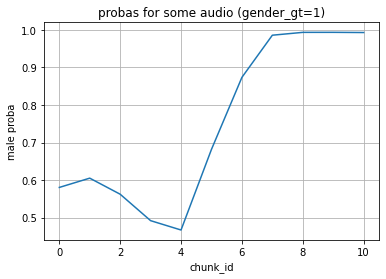

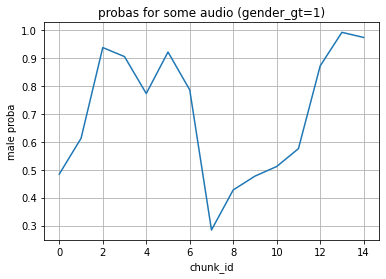

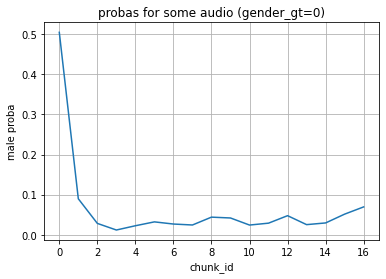

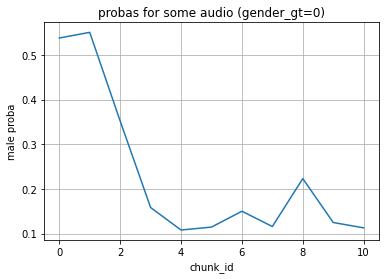

In [101]:
for idx in [1, 100, -100, -1]:
    plt.title(f"probas for some audio (gender_gt={results['data'][idx]['gender_gt']})")
    plt.grid()
    plt.ylabel("male proba")
    plt.xlabel("chunk_id")
    plt.plot(results['data'][idx]['probas'])
    plt.show();

In [102]:
with open('results.pkl', 'rb') as handle:
    results = pickle.load(handle)

chunk_size_ms = results['chunk_size_ms']


for confidence_duration in [chunk_size_ms, 2*chunk_size_ms, 3*chunk_size_ms]:
    confidence_chunks = int(np.ceil(confidence_duration / chunk_size_ms))
    for proba_offset in [0.2, 0.3, 0.4]:
        accuracy_sum = 0
        stats = {
            'num_chunks': [],
            'last_used_chunk': [],
        }
        for elem in tqdm.tqdm(results['data']):
            probas = elem['probas']
            stats['num_chunks'].append(len(probas))
            earlier_stopping = False
            for i in range(len(probas)):
                last_probas = probas[i - confidence_chunks : i]
                if len(last_probas) >= confidence_chunks:
                    if np.min(last_probas) >= 0.5 + proba_offset:  # male
                        stats['last_used_chunk'].append(i)
                        accuracy_sum += int(elem['gender_gt'] == 1)
                        earlier_stopping = True
                        break
                    if np.max(last_probas) <= 0.5 - proba_offset:  # female
                        stats['last_used_chunk'].append(i)
                        accuracy_sum += int(elem['gender_gt'] == 0)
                        earlier_stopping = True
                        break
            if not earlier_stopping:
                stats['last_used_chunk'].append(len(probas) - 1)
                if probas[-1] >= 0.5:
                    accuracy_sum += int(elem['gender_gt'] == 1)
                else:
                    accuracy_sum += int(elem['gender_gt'] == 0)
        fraction = (np.array(stats['last_used_chunk']) + 1) / np.array(stats['num_chunks'])
        print(f"confidence_duration: {confidence_duration} ms")
        print(f"proba_offset: {proba_offset}")
        print(f"fraction of used chunks: {np.mean(fraction) * 100: .2f} %")
        print(f"accuracy: {accuracy_sum / len(results['data']) : .3f}")
        print("=" * 25)

100%|██████████| 784/784 [00:00<00:00, 14897.61it/s]


confidence_duration: 300 ms
proba_offset: 0.2
fraction of used chunks:  39.54 %
accuracy:  0.921


100%|██████████| 784/784 [00:00<00:00, 13527.45it/s]


confidence_duration: 300 ms
proba_offset: 0.3
fraction of used chunks:  43.61 %
accuracy:  0.945


100%|██████████| 784/784 [00:00<00:00, 11963.93it/s]


confidence_duration: 300 ms
proba_offset: 0.4
fraction of used chunks:  48.12 %
accuracy:  0.955


100%|██████████| 784/784 [00:00<00:00, 14436.83it/s]


confidence_duration: 600 ms
proba_offset: 0.2
fraction of used chunks:  48.56 %
accuracy:  0.940


100%|██████████| 784/784 [00:00<00:00, 13146.13it/s]


confidence_duration: 600 ms
proba_offset: 0.3
fraction of used chunks:  52.04 %
accuracy:  0.949


100%|██████████| 784/784 [00:00<00:00, 11886.48it/s]


confidence_duration: 600 ms
proba_offset: 0.4
fraction of used chunks:  56.49 %
accuracy:  0.960


100%|██████████| 784/784 [00:00<00:00, 14491.99it/s]


confidence_duration: 900 ms
proba_offset: 0.2
fraction of used chunks:  56.61 %
accuracy:  0.946


100%|██████████| 784/784 [00:00<00:00, 12909.05it/s]


confidence_duration: 900 ms
proba_offset: 0.3
fraction of used chunks:  60.09 %
accuracy:  0.958


100%|██████████| 784/784 [00:00<00:00, 10876.32it/s]

confidence_duration: 900 ms
proba_offset: 0.4
fraction of used chunks:  64.00 %
accuracy:  0.963


See, that accuracy is better when we use high proba_offset (it's expected) and use sufficient confidence_duration (it's expected).   
From experiments, we can accelerate predictions on ~36% using confidence_duration=900ms and proba_offset=0.4

**Thx for reading!**